<a href="https://colab.research.google.com/github/aaronjoel/ML_Sebastian_Raschka_Notebooks_Exercises/blob/main/Linear_reg_gd.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install watermark --quiet

In [6]:
%reload_ext watermark
%watermark -a 'Sebastian Raschka' -v -p torch,pandas,matplotlib

Author: Sebastian Raschka

Python implementation: CPython
Python version       : 3.10.12
IPython version      : 7.34.0

torch     : 2.3.0+cu121
pandas    : 2.0.3
matplotlib: 3.7.1



# Linear Regression with Gradient Descent

Note that linear regression and Adaline are very similar. The only difference is that we apply a threshold function for converting the outputs from continuous targets for predictions. The derivative and training procedure are identical to Adaline though.

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import torch
%matplotlib inline

## Load & Prepare a Toy Dataset

In [8]:
df = pd.read_csv('https://raw.githubusercontent.com/rasbt/stat453-deep-learning-ss21/main/L05/code/datasets/linreg-data.csv', index_col=0)
df.head()

,x1,x2,y
0,-2.201441,-0.468864,-30.355617
1,-0.291041,0.777277,25.560334
2,-0.327755,0.040071,32.797526
3,-0.075650,1.821915,72.734577
4,-0.862493,-0.467493,-48.072356


In [9]:
df.tail()

,x1,x2,y
995,-0.942094,-0.835856,-22.324428
996,1.222445,-0.403177,-52.121493
997,-0.112466,-1.688230,-57.043196
998,-0.403459,-0.412272,-27.701833
999,0.021351,-0.499017,-9.804714


In [10]:
# Assign features and target
X = torch.tensor(df[['x1', 'x2']].values, dtype=torch.float)
y = torch.tensor(df['y'].values, dtype=torch.float)

X

tensor([[-2.2014, -0.4689],
        [-0.2910,  0.7773],
        [-0.3278,  0.0401],
        ...,
        [-0.1125, -1.6882],
        [-0.4035, -0.4123],
        [ 0.0214, -0.4990]])

In [12]:
y[:10]

tensor([-30.3556,  25.5603,  32.7975,  72.7346, -48.0724,  25.7701,  54.1968,
          1.1069,  -2.2052, -62.6461])

In [13]:
X.shape, y.shape

(torch.Size([1000, 2]), torch.Size([1000]))

In [15]:
# Shuffling & train/test split
torch.manual_seed(123)
shuffle_idx = torch.randperm(y.size(0), dtype=torch.long)
shuffle_idx[:10]

tensor([382, 974, 946,  31, 512,  42, 918, 564, 827, 227])

In [16]:
X, y = X[shuffle_idx], y[shuffle_idx]

percent70 = int(shuffle_idx.size(0) * 0.7)
print(f'percent70: {percent70}')

X_train, X_test = X[shuffle_idx[:percent70]], X[shuffle_idx[percent70:]]
y_train, y_test = y[shuffle_idx[:percent70]], y[shuffle_idx[percent70:]]

# Normalize (mean zero, unit variance)
mu, sigma = X_train.mean(dim=0), X_train.std(dim=0)
X_train = (X_train - mu) / sigma
X_test = (X_test - mu) / sigma

percent70: 700


In [17]:
X_train

tensor([[-1.2445,  0.2304],
        [ 0.9749, -0.3741],
        [ 1.5007,  0.1612],
        ...,
        [-1.4082, -0.8488],
        [-1.0998, -0.5673],
        [ 0.6411, -1.6529]])

In [18]:
X_train.mean(0)

tensor([-1.0899e-08, -1.6349e-08])

In [19]:
X_train.std(0)

tensor([1., 1.])

## Implement Linear Regression Model

In [20]:
class LinearRegression1():
  def __init__(self, num_features):
    self.num_features = num_features
    self.weights = torch.zeros(num_features, 1, dtype=torch.float)
    self.bias = torch.zeros(1, dtype=torch.float)

  def forward(self, x):
    net_inputs = torch.add(torch.mm(x, self.weights), self.bias)
    activations = net_inputs
    return activations.view(-1)

  def backward(self, x, yhat, y):
    grad_loss_yhat = 2 * (yhat - y)
    grad_yhat_weights = x
    grad_yhat_bias = 1.

    # Chain rule: inner times outer
    grad_loss_weights = torch.mm(grad_yhat_weights.t(), grad_loss_yhat.view(-1, 1)) / y.size(0)

    grad_loss_bias = torch.sum(grad_yhat_bias * grad_loss_yhat) / y.size(0)

    # return negative gradient
    return -grad_loss_weights, -grad_loss_bias

## Define Training and Evaluation Functions

In [25]:
#######################################################
####### Training and evaluation wrappers
#######################################################

def loss(yhat, y):
  return torch.mean((yhat - y) ** 2)


def train(model, x, y, num_epochs, learning_rate=0.01):
  cost = []
  for e in range(num_epochs):
    ### Compute outputs ###
    yhat = model.forward(x)

    ### Compute gradients ###
    negative_grad_w, negative_grad_b = model.backward(x, yhat, y)

    ### Update weights ###
    model.weights += learning_rate * negative_grad_w
    model.bias += learning_rate * negative_grad_b

    ### Logging ####
    #yhat = model.forward(x)  # note that this ia a bit wasteful here
    curr_loss = loss(yhat, y)
    print(f"Epoch: {e+1:03d} | MSE: {curr_loss:.5f}")
    cost.append(curr_loss)

  return cost

## Train Linear Regression Model

In [26]:
model = LinearRegression1(num_features=X_train.size(1))

cost = train(model, X_train, y_train, num_epochs=100, learning_rate=0.05)

Epoch: 001 | MSE: 1804.54102
Epoch: 002 | MSE: 1532.67603
Epoch: 003 | MSE: 1312.39868
Epoch: 004 | MSE: 1133.91809
Epoch: 005 | MSE: 989.30286
Epoch: 006 | MSE: 872.12592
Epoch: 007 | MSE: 777.18097
Epoch: 008 | MSE: 700.24915
Epoch: 009 | MSE: 637.91241
Epoch: 010 | MSE: 587.40167
Epoch: 011 | MSE: 546.47284
Epoch: 012 | MSE: 513.30811
Epoch: 013 | MSE: 486.43430
Epoch: 014 | MSE: 464.65799
Epoch: 015 | MSE: 447.01224
Epoch: 016 | MSE: 432.71332
Epoch: 017 | MSE: 421.12634
Epoch: 018 | MSE: 411.73697
Epoch: 019 | MSE: 404.12827
Epoch: 020 | MSE: 397.96249
Epoch: 021 | MSE: 392.96603
Epoch: 022 | MSE: 388.91708
Epoch: 023 | MSE: 385.63583
Epoch: 024 | MSE: 382.97684
Epoch: 025 | MSE: 380.82202
Epoch: 026 | MSE: 379.07571
Epoch: 027 | MSE: 377.66052
Epoch: 028 | MSE: 376.51367
Epoch: 029 | MSE: 375.58420
Epoch: 030 | MSE: 374.83102
Epoch: 031 | MSE: 374.22055
Epoch: 032 | MSE: 373.72586
Epoch: 033 | MSE: 373.32489
Epoch: 034 | MSE: 372.99994
Epoch: 035 | MSE: 372.73657
Epoch: 036 | MSE

## Evaluate Linear Regression Model

### Plot MSE

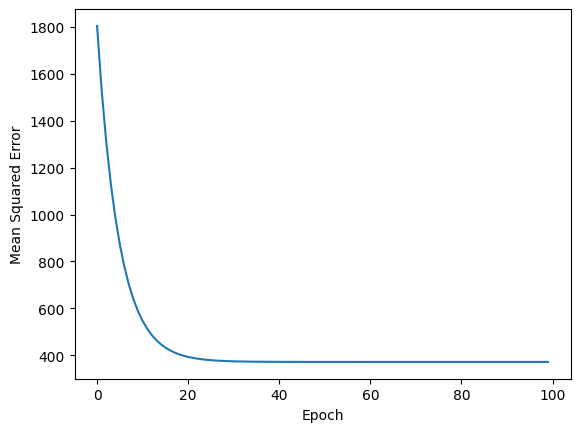

In [27]:
plt.plot(range(len(cost)), cost)
plt.ylabel('Mean Squared Error')
plt.xlabel('Epoch')
plt.show();

In [28]:
#######################################################
####### Training and evaluation wrappers
#######################################################

def loss(yhat, y):
  return torch.mean((yhat - y) ** 2)


def train(model, x, y, num_epochs, learning_rate=0.01):
  cost = []
  for e in range(num_epochs):
    ### Compute outputs ###
    yhat = model.forward(x)

    ### Compute gradients ###
    negative_grad_w, negative_grad_b = model.backward(x, yhat, y)

    ### Update weights ###
    model.weights += learning_rate * negative_grad_w
    model.bias += learning_rate * negative_grad_b

    ### Logging ####
    yhat = model.forward(x)  # note that this ia a bit wasteful here
    curr_loss = loss(yhat, y)
    print(f"Epoch: {e+1:03d} | MSE: {curr_loss:.5f}")
    cost.append(curr_loss)

  return cost

In [29]:
model = LinearRegression1(num_features=X_train.size(1))
cost = train(model,
             X_train, y_train,
             num_epochs=100,
             learning_rate=0.05)

Epoch: 001 | MSE: 1532.67603
Epoch: 002 | MSE: 1312.39868
Epoch: 003 | MSE: 1133.91809
Epoch: 004 | MSE: 989.30286
Epoch: 005 | MSE: 872.12592
Epoch: 006 | MSE: 777.18097
Epoch: 007 | MSE: 700.24915
Epoch: 008 | MSE: 637.91241
Epoch: 009 | MSE: 587.40167
Epoch: 010 | MSE: 546.47284
Epoch: 011 | MSE: 513.30811
Epoch: 012 | MSE: 486.43430
Epoch: 013 | MSE: 464.65799
Epoch: 014 | MSE: 447.01224
Epoch: 015 | MSE: 432.71332
Epoch: 016 | MSE: 421.12634
Epoch: 017 | MSE: 411.73697
Epoch: 018 | MSE: 404.12827
Epoch: 019 | MSE: 397.96249
Epoch: 020 | MSE: 392.96603
Epoch: 021 | MSE: 388.91708
Epoch: 022 | MSE: 385.63583
Epoch: 023 | MSE: 382.97684
Epoch: 024 | MSE: 380.82202
Epoch: 025 | MSE: 379.07571
Epoch: 026 | MSE: 377.66052
Epoch: 027 | MSE: 376.51367
Epoch: 028 | MSE: 375.58420
Epoch: 029 | MSE: 374.83102
Epoch: 030 | MSE: 374.22055
Epoch: 031 | MSE: 373.72586
Epoch: 032 | MSE: 373.32489
Epoch: 033 | MSE: 372.99994
Epoch: 034 | MSE: 372.73657
Epoch: 035 | MSE: 372.52313
Epoch: 036 | MSE:

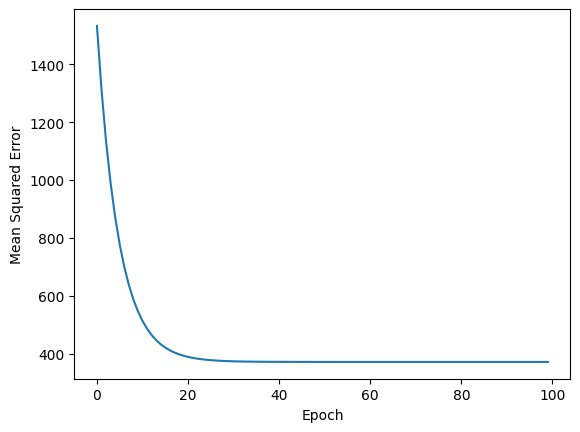

In [30]:
plt.plot(range(len(cost)), cost)
plt.ylabel('Mean Squared Error')
plt.xlabel('Epoch')
plt.show();

In [31]:
train_pred = model.forward(X_train)
test_pred = model.forward(X_test)

print(f'Train MSE: {loss(train_pred, y_train):.5f}')
print(f'Test MSE:  {loss(test_pred, y_test):.5f}')

Train MSE: 371.61035
Test MSE:  406.88412


## Compare with analytical solution

In [32]:
print(f'Weights:\n {model.weights}')
print(f'Bias:\n {model.bias}')

Weights:
 tensor([[ 0.3623],
        [37.8790]])
Bias:
 tensor([-0.5464])


In [33]:
def analytical_solution(x, y):
  Xb = torch.cat( (torch.ones((x.size(0), 1)), x), dim=1)
  w = torch.zeros(x.size(1))
  z = torch.inverse(torch.matmul(Xb.t(), Xb))
  params = torch.matmul(z, torch.matmul(Xb.t(), y))
  b, w = torch.tensor([params[0]]), params[1:].view(x.size(1), 1)
  return w, b

In [34]:
w, b = analytical_solution(X_train, y_train)
print(f'Analytical weights:\n{w}')
print(f'Analytical bias:\n{b}')

Analytical weights:
tensor([[ 0.3624],
        [37.8801]])
Analytical bias:
tensor([-0.5464])


In [35]:
n = X_train.size(0)
n

700

In [37]:
ones = torch.ones((n, 1))
ones[:10]

tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]])

In [38]:
Xb = torch.cat((ones, X_train), dim=1)
Xb

tensor([[ 1.0000, -1.2445,  0.2304],
        [ 1.0000,  0.9749, -0.3741],
        [ 1.0000,  1.5007,  0.1612],
        ...,
        [ 1.0000, -1.4082, -0.8488],
        [ 1.0000, -1.0998, -0.5673],
        [ 1.0000,  0.6411, -1.6529]])

In [39]:
w = torch.zeros(X_train.size(1))
w

tensor([0., 0.])

In [41]:
z = torch.inverse(Xb.T @ Xb)
params = z @ Xb.T @ y_train
params.shape

torch.Size([3])

In [42]:
params[0]

tensor(-0.5464)

In [43]:
params[1:]

tensor([ 0.3624, 37.8801])

In [44]:
b = torch.tensor([params[0]])
b

tensor([-0.5464])

In [45]:
w = params[1:].view(-1, 1)
w

tensor([[ 0.3624],
        [37.8801]])

## Shuffling before training

In [46]:
#######################################################
####### Training and evaluation wrappers
#######################################################

def loss(yhat, y):
  return torch.mean((yhat - y) ** 2)


def train(model, x, y, num_epochs, learning_rate=0.01):
  cost = []
  for e in range(num_epochs):
    ## Shuffling training data before each epoch
    shuffle_idx = torch.randperm(y.size(0), dtype=torch.long)
    x, y = x[shuffle_idx], y[shuffle_idx]

    ### Compute outputs ###
    yhat = model.forward(x)

    ### Compute gradients ###
    negative_grad_w, negative_grad_b = model.backward(x, yhat, y)

    ### Update weights ###
    model.weights += learning_rate * negative_grad_w
    model.bias += learning_rate * negative_grad_b

    ### Logging ####
    yhat = model.forward(x)  # note that this ia a bit wasteful here
    curr_loss = loss(yhat, y)
    print(f"Epoch: {e+1:03d} | MSE: {curr_loss:.5f}")
    cost.append(curr_loss)

  return cost

In [47]:
model = LinearRegression1(num_features=X_train.size(1))
cost = train(model,
             X_train, y_train,
             num_epochs=100,
             learning_rate=0.05)

Epoch: 001 | MSE: 1532.67603
Epoch: 002 | MSE: 1312.39844
Epoch: 003 | MSE: 1133.91809
Epoch: 004 | MSE: 989.30286
Epoch: 005 | MSE: 872.12610
Epoch: 006 | MSE: 777.18115
Epoch: 007 | MSE: 700.24939
Epoch: 008 | MSE: 637.91266
Epoch: 009 | MSE: 587.40186
Epoch: 010 | MSE: 546.47302
Epoch: 011 | MSE: 513.30823
Epoch: 012 | MSE: 486.43442
Epoch: 013 | MSE: 464.65811
Epoch: 014 | MSE: 447.01233
Epoch: 015 | MSE: 432.71344
Epoch: 016 | MSE: 421.12643
Epoch: 017 | MSE: 411.73706
Epoch: 018 | MSE: 404.12836
Epoch: 019 | MSE: 397.96259
Epoch: 020 | MSE: 392.96613
Epoch: 021 | MSE: 388.91714
Epoch: 022 | MSE: 385.63593
Epoch: 023 | MSE: 382.97687
Epoch: 024 | MSE: 380.82202
Epoch: 025 | MSE: 379.07574
Epoch: 026 | MSE: 377.66052
Epoch: 027 | MSE: 376.51367
Epoch: 028 | MSE: 375.58423
Epoch: 029 | MSE: 374.83099
Epoch: 030 | MSE: 374.22055
Epoch: 031 | MSE: 373.72586
Epoch: 032 | MSE: 373.32492
Epoch: 033 | MSE: 372.99997
Epoch: 034 | MSE: 372.73660
Epoch: 035 | MSE: 372.52316
Epoch: 036 | MSE:

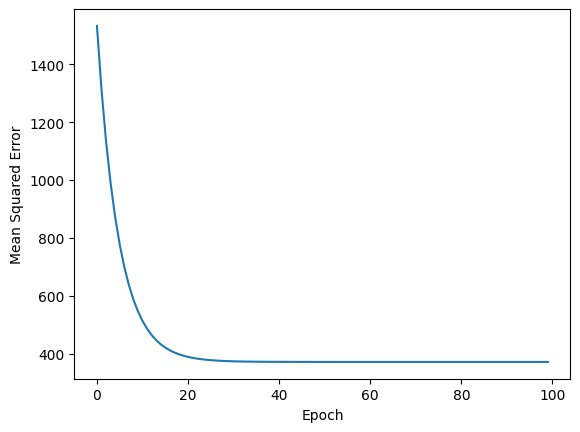

In [48]:
plt.plot(range(len(cost)), cost)
plt.ylabel('Mean Squared Error')
plt.xlabel('Epoch')
plt.show();

## Implementing Adaline

In [49]:
df = pd.read_csv("https://raw.githubusercontent.com/rasbt/stat453-deep-learning-ss21/main/L05/code/datasets/iris.data", index_col=None, header=None)
df.columns = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'class']
df.head()

,sepal_length,sepal_width,petal_length,petal_width,class
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


In [50]:
df = df.iloc[50:150]
df.head()

,sepal_length,sepal_width,petal_length,petal_width,class
50,7.0,3.2,4.7,1.4,Iris-versicolor
51,6.4,3.2,4.5,1.5,Iris-versicolor
52,6.9,3.1,4.9,1.5,Iris-versicolor
53,5.5,2.3,4.0,1.3,Iris-versicolor
54,6.5,2.8,4.6,1.5,Iris-versicolor


In [51]:
df['class'] = df['class'].apply(lambda x: 0 if x == 'Iris-versicolor' else 1)
df['class']

50     0
51     0
52     0
53     0
54     0
      ..
145    1
146    1
147    1
148    1
149    1
Name: class, Length: 100, dtype: int64

In [52]:
df.tail()

,sepal_length,sepal_width,petal_length,petal_width,class
145,6.7,3.0,5.2,2.3,1
146,6.3,2.5,5.0,1.9,1
147,6.5,3.0,5.2,2.0,1
148,6.2,3.4,5.4,2.3,1
149,5.9,3.0,5.1,1.8,1


In [54]:
# Assign features and target

X = torch.tensor(df[['sepal_width', 'petal_length']].values, dtype=torch.float)
y = torch.tensor(df['class'].values, dtype=torch.int)

X.shape, y.shape

(torch.Size([100, 2]), torch.Size([100]))

In [55]:
# Shuffling & train/test split
torch.manual_seed(123)
shuffle_idx = torch.randperm(y.size(0), dtype=torch.long)

X, y = X[shuffle_idx], y[shuffle_idx]
percent70 = int(shuffle_idx.size(0) * 0.7)

X_train, X_test = X[shuffle_idx[:percent70]], X[shuffle_idx[percent70:]]
y_train, y_test = y[shuffle_idx[:percent70]], y[shuffle_idx[percent70:]]


# Normalize (mean zero, unit variance)
mu, sigma = X_train.mean(dim=0), X_train.std(dim=0)
X_train = (X_train - mu) / sigma
X_test = (X_test - mu) / sigma


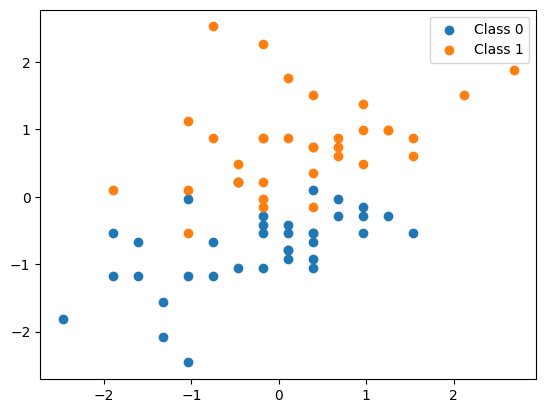

In [56]:
plt.scatter(X_train[y_train==0, 0], X_train[y_train==0, 1], label='Class 0')
plt.scatter(X_train[y_train==1, 0], X_train[y_train==1, 1], label='Class 1')
plt.legend()
plt.show()

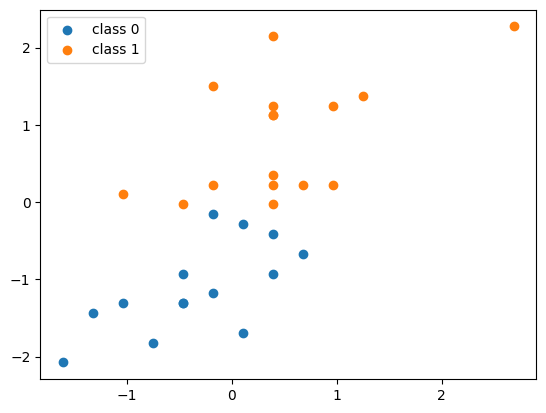

In [57]:
plt.scatter(X_test[y_test == 0, 0], X_test[y_test == 0, 1], label='class 0')
plt.scatter(X_test[y_test == 1, 0], X_test[y_test == 1, 1], label='class 1')
plt.legend()
plt.show()

In [58]:
class Adaline1():
    def __init__(self, num_features):
        self.num_features = num_features
        self.weights = torch.zeros(num_features, 1,
                                   dtype=torch.float)
        self.bias = torch.zeros(1, dtype=torch.float)

    def forward(self, x):
        netinputs = torch.add(torch.mm(x, self.weights), self.bias)
        activations = netinputs
        return activations.view(-1)

    def backward(self, x, yhat, y):

        grad_loss_yhat = 2*(yhat - y)

        grad_yhat_weights = x
        grad_yhat_bias = 1.

        # Chain rule: inner times outer
        grad_loss_weights = torch.mm(grad_yhat_weights.t(),
                                         grad_loss_yhat.view(-1, 1)) / y.size(0)

        grad_loss_bias = torch.sum(grad_yhat_bias*grad_loss_yhat) / y.size(0)

        # return negative gradient
        return (-1)*grad_loss_weights, (-1)*grad_loss_bias

In [59]:
def loss(yhat, y):
  return torch.mean((yhat - y)**2)


def train(model, x, y, num_epochs, learning_rate=0.01, seed=123, minibatch_size=None):
  cost = []

  torch.manual_seed(seed)
  for e in range(num_epochs):

    ## Shuffle epoch
    shuffle_idx = torch.randperm(y.size(0), dtype=torch.long)
    minibatches = torch.split(shuffle_idx, minibatch_size)

    for minibatch_idx in minibatches:
      ### Compute outputs
      yhat = model.forward(x[minibatch_idx])

      ### Compute gradients
      negative_grad_w, negative_grad_b = model.backward(x[minibatch_idx], yhat, y[minibatch_idx])

      ## Update weights
      model.weights += learning_rate * negative_grad_w
      model.bias += learning_rate * negative_grad_b

      ## Logging
      minibatch_loss = loss(yhat, y[minibatch_idx])
      print(f'   Minibatch MSE: {minibatch_loss:.3f}')

    ### Logging
    yhat = model.forward(x)
    curr_loss = loss(yhat, y)
    print(f"Epoch: {e+1:03d} | MSE: {curr_loss:.5f}")
    cost.append(curr_loss)

  return cost

In [60]:
model = Adaline1(num_features=X_train.size(1))

cost = train(model,
             X_train,
             y_train,
             num_epochs=20,
             learning_rate=0.1,
             seed=123,
             minibatch_size=10)

   Minibatch MSE: 0.500
   Minibatch MSE: 0.341
   Minibatch MSE: 0.220
   Minibatch MSE: 0.245
   Minibatch MSE: 0.157
   Minibatch MSE: 0.133
   Minibatch MSE: 0.144
Epoch: 001 | MSE: 0.12142
   Minibatch MSE: 0.107
   Minibatch MSE: 0.147
   Minibatch MSE: 0.064
   Minibatch MSE: 0.079
   Minibatch MSE: 0.185
   Minibatch MSE: 0.063
   Minibatch MSE: 0.135
Epoch: 002 | MSE: 0.09932
   Minibatch MSE: 0.093
   Minibatch MSE: 0.064
   Minibatch MSE: 0.128
   Minibatch MSE: 0.099
   Minibatch MSE: 0.079
   Minibatch MSE: 0.157
   Minibatch MSE: 0.080
Epoch: 003 | MSE: 0.09693
   Minibatch MSE: 0.131
   Minibatch MSE: 0.146
   Minibatch MSE: 0.050
   Minibatch MSE: 0.095
   Minibatch MSE: 0.106
   Minibatch MSE: 0.072
   Minibatch MSE: 0.102
Epoch: 004 | MSE: 0.09658
   Minibatch MSE: 0.107
   Minibatch MSE: 0.204
   Minibatch MSE: 0.149
   Minibatch MSE: 0.054
   Minibatch MSE: 0.060
   Minibatch MSE: 0.056
   Minibatch MSE: 0.069
Epoch: 005 | MSE: 0.09657
   Minibatch MSE: 0.068
   Min

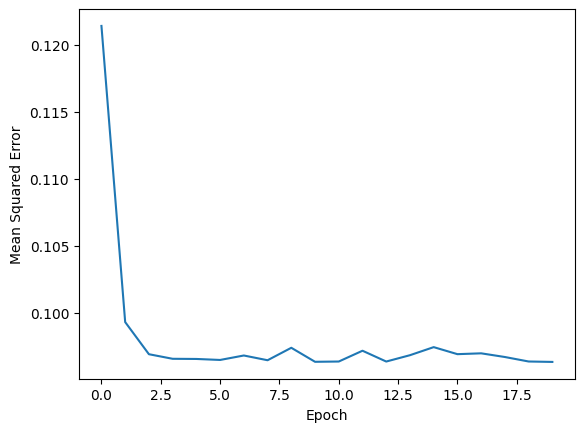

In [61]:
plt.plot(range(len(cost)), cost)
plt.ylabel('Mean Squared Error')
plt.xlabel('Epoch')
plt.show()

In [62]:
print('Weights', model.weights)
print('Bias', model.bias)

Weights tensor([[-0.0763],
        [ 0.4181]])
Bias tensor([0.4888])


In [63]:
def analytical_solution(x, y):
    Xb = torch.cat( (torch.ones((x.size(0), 1)), x), dim=1)
    w = torch.zeros(x.size(1))
    z = torch.inverse(torch.matmul(Xb.t(), Xb))
    params = torch.matmul(z, torch.matmul(Xb.t(), y))
    b, w = torch.tensor([params[0]]), params[1:].view(x.size(1), 1)
    return w, b

w, b = analytical_solution(X_train, y_train.float())
print('Analytical weights', w)
print('Analytical bias', b)

Analytical weights tensor([[-0.0703],
        [ 0.4219]])
Analytical bias tensor([0.4857])


## Evaluate on Evaluation Metric (Prediction Accuracy)

In [64]:
ones = torch.ones(y_train.size())
ones

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [65]:
zeros = torch.zeros(y_train.size())
zeros

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [66]:
train_pred = model.forward(X_train)
train_acc = torch.mean(
    (torch.where(train_pred > 0.5, ones, zeros).int() == y_train).float()
)

train_acc

tensor(0.9000)

In [67]:
ones = torch.ones(y_test.size())
zeros = torch.zeros(y_test.size())
test_pred = model.forward(X_test)
test_acc = torch.mean(
    (torch.where(test_pred > 0.5,
                 ones,
                 zeros).int() == y_test).float())

print('Training Accuracy: %.2f' % (train_acc*100))
print('Test Accuracy: %.2f' % (test_acc*100))

Training Accuracy: 90.00
Test Accuracy: 96.67


In [68]:
## Decision Boundary

In [69]:
w, b = model.weights, model.bias - 0.5

In [70]:
x_min = -3
y_min =  (-(w[0] * x_min) - b[0]) / w[1]

x_max = 3
y_max =  (-(w[0] * x_max) - b[0]) / w[1]

x_min, y_min, x_max, y_max

(-3, tensor([-0.5203]), 3, tensor([0.5738]))

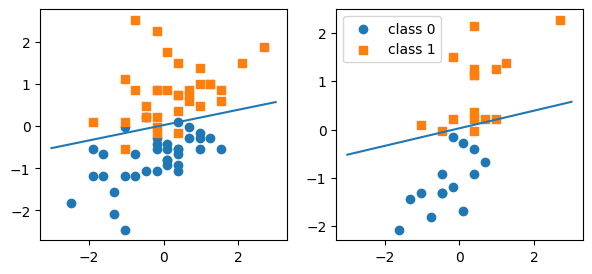

In [72]:
fig, ax = plt.subplots(1, 2, sharex=True, figsize=(7, 3))

ax[0].plot([x_min, x_max], [y_min, y_max])
ax[1].plot([x_min, x_max], [y_min, y_max])

ax[0].scatter(X_train[y_train==0, 0], X_train[y_train==0, 1], label='Class 0', marker='o')
ax[0].scatter(X_train[y_train==1, 0], X_train[y_train==1, 1], label='Class 1', marker='s')

ax[1].scatter(X_test[y_test==0, 0], X_test[y_test==0, 1], label='class 0', marker='o')
ax[1].scatter(X_test[y_test==1, 0], X_test[y_test==1, 1], label='class 1', marker='s')

ax[1].legend(loc='upper left')
plt.show()
